In [1]:
import torch
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2


import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.stochastic_interpolant as stochastic_interpolant
from torch import autograd
from functorch import jacfwd, vmap


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found!')
print(itf.util.get_torch_device())


print("Torch version:", torch.__version__)

No CUDA device found!
cpu
Torch version: 2.3.1+cpu


## Utility functions

In [2]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()


def compute_likelihoods(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    
    sde_flow = stochastic_interpolant.SDEIntegrator(
        b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    )
    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)
    
    with torch.no_grad():
        x0_tests  = base(bs)
        xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
        xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]
        # ([1, bs, dim], [bs])
        x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    

    logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return xf_sde, xf_pflow, logpx_pflow


def log_metrics(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int, 
    b_loss: torch.tensor,
    s_loss: torch.tensor,
    loss: torch.tensor,
    b_grad: torch.tensor,
    s_grad: torch.tensor,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    # log loss and gradient data
    b_loss   = grab(b_loss).mean(); data_dict['b_losses'].append(b_loss)
    s_loss   = grab(s_loss).mean(); data_dict['s_losses'].append(s_loss)
    loss     = grab(loss).mean(); data_dict['losses'].append(loss)
    b_grad   = grab(b_grad).mean(); data_dict['b_grads'].append(b_grad)
    s_grad   = grab(s_grad).mean(); data_dict['s_grads'].append(s_grad)

    
    # compute and log likelihood data
    _, _, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs)
    
    logpx_pflow = grab(logpx_pflow).mean(); data_dict['logps_pflow'].append(logpx_pflow)
    
    
def make_plots(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int, ## number of sde steps in [0,1]
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    xf_sde, xf_pflow, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs
    )


    ### plot the loss, test logp, and samples from interpolant flow
    fig, axes = plt.subplots(1,4, figsize=(16,4))
    print("EPOCH:", counter)
    print("LOSS, GRAD:", loss, b_grad, s_grad)


    # plot loss over time.
    nsaves = len(data_dict['losses'])
    epochs = np.arange(nsaves)*metrics_freq
    axes[0].plot(epochs, data_dict['losses'], label=" b + s")
    axes[0].plot(epochs, data_dict['b_losses'], label="b")
    axes[0].plot(epochs, data_dict['s_losses'], label = "s" )
    axes[0].set_title("LOSS")
    axes[0].legend()


    # plot samples from SDE.
    axes[1].scatter(
        xf_sde[:,0], xf_sde[:,1], vmin=0.0, vmax=0.05, alpha = 0.2)
    axes[1].set_xlim(-5,5)
    axes[1].set_ylim(-6.5,6.5)
    axes[1].set_title("Samples from SDE", fontsize=14)


    # plot samples from pflow
    axes[2].scatter(
        xf_pflow[:,0], xf_pflow[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_pflow).detach()))
    axes[2].set_xlim(-5,5)
    axes[2].set_ylim(-6.5,6.5)
    axes[2].set_title("Samples from PFlow", fontsize=14)


    # plot likelihood estimates.
    axes[3].plot(epochs, data_dict['logps_pflow'],   label='pflow', color='purple')
    axes[3].set_title(r"$\log p$ from PFlow")
    axes[3].legend(loc='best')
    axes[3].set_ylim(-7,0)


    fig.suptitle(r"$\epsilon = $" + str(grab(eps)),  fontsize=16, y = 1.05)
    plt.show()
    
    


def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt_b  : Any,
    opt_s  : Any,
    sched_b: Any, 
    sched_s: Any,
):
    """
    Take a single step of optimization on the training set.
    """
    opt_b.zero_grad()
    opt_s.zero_grad()


    # construct batch
    x0s = base(bs)
    x1s = target(bs)
    ts  = torch.rand(size=(bs,))


    # compute the loss
    loss_start = time.perf_counter()
    loss_b     = loss_fn_b(b, x0s, x1s, ts, interpolant)
    loss_s     = loss_fn_s(s, x0s, x1s, ts, interpolant)
    loss_val   = loss_b + loss_s
    loss_end   = time.perf_counter()


    # compute the gradient
    backprop_start = time.perf_counter()
    loss_b.backward()
    loss_s.backward()
    b_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(b.parameters(), float('inf'))])
    s_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(s.parameters(), float('inf'))])
    backprop_end = time.perf_counter()


    # perform the update.
    update_start = time.perf_counter()
    opt_b.step()
    opt_s.step()
    sched_b.step()
    sched_s.step()
    update_end = time.perf_counter()


    if counter < 5:
        print(f'[Loss: {loss_end - loss_start}], [Backprop: {backprop_end-backprop_start}], [Update: {update_end-update_start}].')


    return loss_val.detach(), loss_b.detach(), loss_s.detach(), b_grad.detach(), s_grad.detach()

### Define target

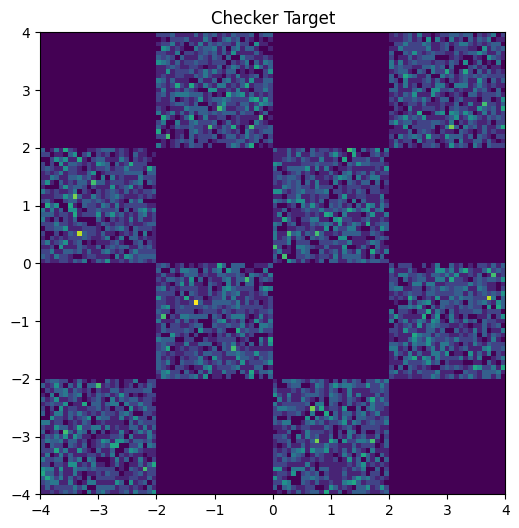

Batch Shape: (10000, 2)


In [3]:

ndim = 2
def target(bs):
    x1 = torch.rand(bs) * 4 - 2
    x2_ = torch.rand(bs) - torch.randint(2, (bs,)) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)


target_samples = grab(target(10000))


fig = plt.figure(figsize=(6,6))
plt.hist2d(target_samples[:,0], target_samples[:,1], bins = 100, range=[[-4,4],[-4,4]]);
plt.title("Checker Target")
plt.show()


print("Batch Shape:", target_samples.shape)
# target_logp_est = target.log_prob(target(10000)).mean()

### Define Base Distribution

In [4]:
base_loc     = torch.zeros(ndim)
base_var     = torch.ones(ndim)
base         = prior.SimpleNormal(base_loc, 1.0*base_var)
base_samples = grab(base(20000))

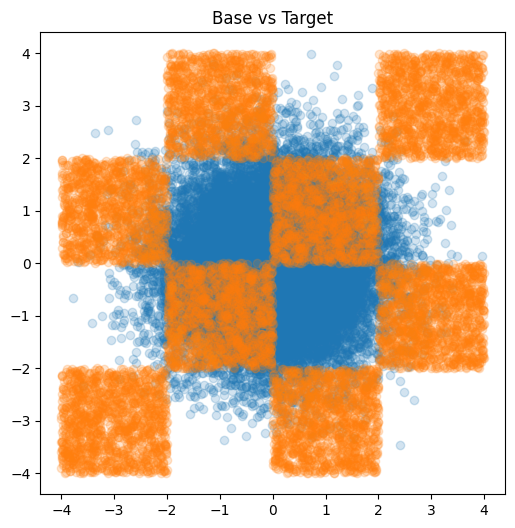

In [5]:
fig = plt.figure(figsize=(6,6,))
plt.scatter(base_samples[:,0], base_samples[:,1],  label = 'base', alpha = 0.2);
plt.scatter(target_samples[:,0], target_samples[:,1], alpha = 0.2);
plt.title("Bimodal Target")
plt.title("Base vs Target")
plt.show()

### Define Interpolant: A one sided interpolant, meaning that $x_0 \sim N(0,1)$

In [6]:
# gamma_type = 'brownian'
path = 'one-sided-linear'
interpolant  = stochastic_interpolant.Interpolant(path=path, gamma_type=None)

### Define losses for b and s

In [7]:
loss_fn_b = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-b')
loss_fn_s = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-s')

### Define velocity field and optimizers

In [10]:
base_lr      = 2e-3
hidden_sizes = [256, 256, 256, 256]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = True


b       = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
s       = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_b   = torch.optim.Adam(b.parameters(), lr=base_lr)
opt_s   = torch.optim.Adam(s.parameters(), lr=base_lr)
sched_b = torch.optim.lr_scheduler.StepLR(optimizer=opt_b, step_size=1500, gamma=0.4)
sched_s = torch.optim.lr_scheduler.StepLR(optimizer=opt_s, step_size=1500, gamma=0.4)


eps          = torch.tensor(0.5)
N_era        = 14
N_epoch      = 500
plot_bs      = 5000  # number of samples to use when plotting
bs           = 2000    # number of samples from rho_0 in batch
metrics_freq = 50    # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
plot_freq    = 500   # how often to plot
n_save       = 10    # how often to checkpoint SDE integrator
loss_fac     = 4.0   # ratio of learning rates for w to v
n_step       = 100   # number of steps taken by the SDE in [0,1]


if print_model:
    print("Here's the model b, s:", b, s)

Here's the model b, s: InputWrapper(
  (v): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
) InputWrapper(
  (v): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
)


[Loss: 0.7659618999999793], [Backprop: 0.04261139999999841], [Update: 0.009257099999956608].
EPOCH: 1
LOSS, GRAD: tensor(-0.0156) tensor([0.9037]) tensor([0.9099])


C:\Users\szymon\AppData\Local\Temp\ipykernel_15540\3292071916.py:109: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  axes[1].scatter(


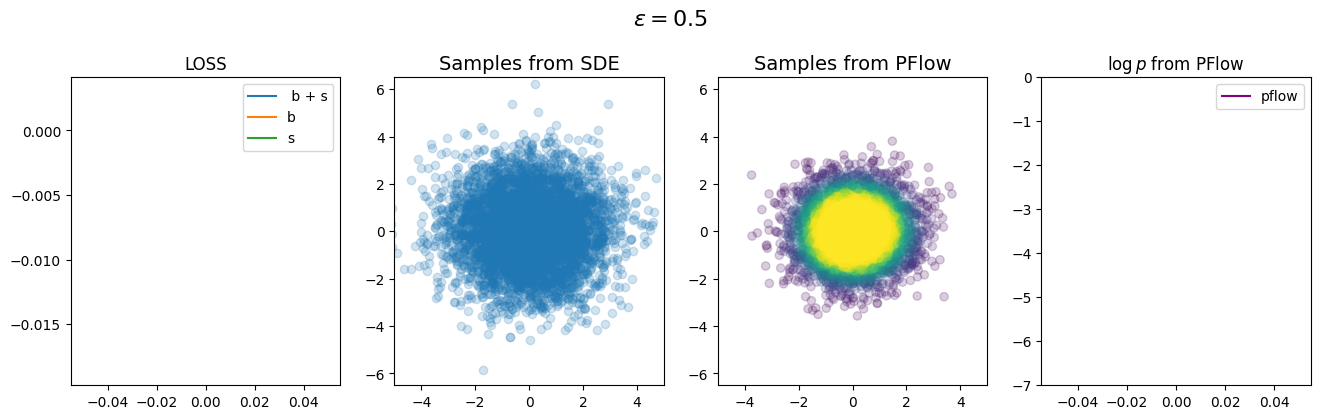

[Loss: 0.020426799999995637], [Backprop: 0.03901810000002115], [Update: 0.004846500000041942].
[Loss: 0.024200699999994413], [Backprop: 0.045767399999988356], [Update: 0.004521500000009837].
[Loss: 0.023244399999953202], [Backprop: 0.046679600000004484], [Update: 0.004499199999997927].


KeyboardInterrupt: 

In [9]:
data_dict = {
    'losses': [],
    'b_losses': [],
    's_losses': [],
    'b_grads': [],
    's_grads': [],
    'times': [],
    'logps_pflow': [],
}

counter = 1
for i, era in enumerate(range(N_era)):
    for j, epoch in enumerate(range(N_epoch)):
        loss, b_loss, s_loss, b_grad, s_grad = train_step(bs, interpolant, opt_b, opt_s, sched_b, sched_s,
        )


        if (counter - 1) % metrics_freq == 0:
            log_metrics(b, s, interpolant, n_save, n_step, bs, b_loss, 
                        s_loss, loss, b_grad, s_grad, eps, data_dict)


        if (counter - 1) % plot_freq == 0:
            make_plots(b, s, interpolant, n_save, n_step, plot_bs, counter, metrics_freq, eps, data_dict)


        counter+=1